In [1]:
import torch
import numpy as np
import warnings
from Bio.PDB import PDBIO, Chain, Residue, Polypeptide, Atom, PDBParser, Selection
from Bio.PDB.PDBExceptions import PDBConstructionWarning
from protein_residues import normal as RESIDUES
from Bio.SeqUtils import seq1, seq3
warnings.simplefilter('error')
list_path = "./data/pdb_list"
pdb_path ="./data/dompdb/"
parser = PDBParser(QUIET=True)

In [2]:
def PROCESS_RESIDUES(d):
    #X is unknown AA I should check this function to incorporate X
    #Additional AA, B - Asparagine, U - selenocysteine, Z - glutamic
    #acid, and O - ornithine (Doesn't clash with IUPAC convention)
    d['HIS'] = d['HIP']
    d = {key: val for key, val in d.items() if seq1(key) != 'X'}
    for key in d:
        atoms = d[key]['atoms']
        d[key] = {'CA': 'C'} | {key: val['symbol'] for key, val in atoms.items() if val['symbol'] != 'H' and key != 'CA'}
    return d
RESIDUES = PROCESS_RESIDUES(RESIDUES)

In [3]:
global_vars = np.zeros(3)[None,:]
filtered_pdb_ids =[]
seq_length = []
multi_chain = []
with open(list_path) as file:
    lines = [line.rstrip() for line in file]

In [4]:
for i in lines:
    model = parser.get_structure('',pdb_path+i)[0]
    chain = model.child_list[0]
    chain_seq = ''
    try:
        chain_bb =np.zeros((1,3))
        for res in chain:
            if (res.id[0] != ' ') or ('CA' not in res.child_dict) or (res.resname not in RESIDUES): continue
            chain_seq+=res.resname
        #Might change the Cb portion of Gly
            if res.resname=="GLY":
                bb = np.stack((res["N"].coord,res["CA"].coord,res["C"].coord),axis=0)
                chain_bb = np.concatenate((chain_bb, bb), axis = 0)
                # global_vars = np.concatenate((global_vars, bb),axis=0)
            else:
                bb = np.stack((res["N"].coord,res["CA"].coord,res["C"].coord,res["CB"].coord),axis=0)
                chain_bb = np.concatenate((chain_bb, bb), axis = 0)
        chain_bb = chain_bb[1:]
        CoM = np.mean(chain_bb,axis=0)
        chain_bb = chain_bb-CoM
        global_vars = np.concatenate((global_vars, chain_bb),axis=0)
        if len(chain_seq)>0:
            seq_length.append(len(seq1(chain_seq)))
            filtered_pdb_ids.append(i)
        if len(model.child_list)>1:
            multi_chain.append(True)
        else:
            multi_chain.append(False)
    except:
        pass

In [8]:
clean = global_vars[1:]

In [ ]:
#Output is
# global_vars = [] -> To calculate global variance
# filtered_pdb_ids =[] -> All PDBs where C, Ca, Cb, N exists
# seq_length = [] -> The sequence length of each pdb
# multi_chain = [] -> Boolean which indicates if the PDB contains multiple chains

# Data Visualization

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

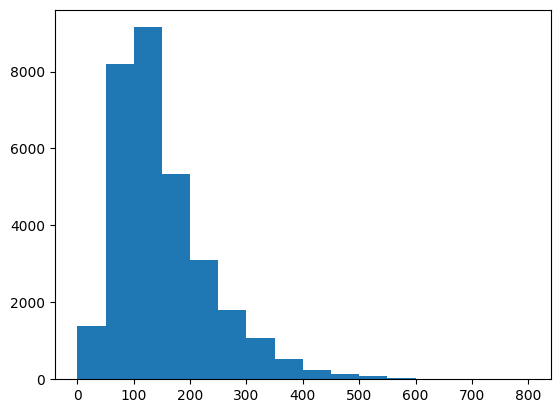

In [17]:
plt.hist(seq_length,bins=16,range=(0,800))
plt.show()

In [24]:
data=pd.DataFrame({'pdb_id':filtered_pdb_ids,'seq_length':seq_length,'is_multi_chain':multi_chain})

In [36]:
print(np.mean(global_vars,axis=0))#Sanity check, mean should be lim -> 0 if centered correctly
global_std = np.sqrt(np.var(global_vars.flatten()))
print(global_std)
std_3d=np.sqrt(np.var(global_vars,axis=0))
print(std_3d)

[2.57252928e-17 1.43223301e-15 6.67425759e-16]
9.975088793405108
[ 9.87331813  9.89513036 10.15436722]


In [38]:
with open('clean_pdb_id.txt', 'w') as f:
    for line in filtered_pdb_ids:
        f.write(f"{line}\n")

# Testing Stuff

# Validate Noising Function

In [108]:
import data_read
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [109]:
pdb_dir ='./data/dompdb/'
list_path = 'data/clean_pdb_id.txt'

In [110]:
class Diffusion(nn.Module):

    def __init__(self, T, b_initial, b_final, device):
        super().__init__()
        self.T = T
        self.beta = torch.linspace(b_initial,b_final,T).to(device)
        
    def _CoMGaussNoise(self, x_t1, t1, t2):
        if t2 == 0:
            a_mul = torch.prod(1-self.beta[0])
        else:
            a_mul = torch.prod(1-self.beta[t1:t2+1])
        eps = torch.normal(mean=torch.zeros_like(x_t1),std=torch.ones_like(x_t1))
        x1_mean = torch.mean(x_t1.flatten(end_dim=-2),dim=-2, keepdim=True)[None,:]
        eps = eps - x1_mean 
        x_t2 = torch.sqrt(a_mul)*x_t1 + torch.sqrt(1-a_mul)*eps
        return x_t2, eps

    def _GaussNoise(self, x_t1, t1, t2):
        if t2 == 0:
            a_mul = torch.prod(1-self.beta[0])
        else:
            a_mul = torch.prod(1-self.beta[t1:t2+1])
        eps = torch.normal(mean=torch.zeros_like(x_t1),std=torch.ones_like(x_t1))
        x_t2 = torch.sqrt(a_mul)*x_t1 + torch.sqrt(1-a_mul)*eps
        #Same output has the same shape as the input
        return x_t2, eps
        
    def forward(self, x, h, t2):
        x_perturbed, x_eps = self._GaussNoise(x, 0, t2)
        h_perturbed, h_eps = self._GaussNoise(h,0,t2)
        return x_perturbed, x_eps, h_perturbed, h_eps

In [111]:
def plot_protein(frames):
    """
    Plots a protein diagram from an array of 3D coordinates
        Args: 
        frame: 3D coordinates generated by backbone. Shape - n_aa x 4 x 3
            second dimension representing N, CA, C, CB
    """
    CA_coords = frames[:,0,:]
    #Plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(CA_coords[:, 0], CA_coords[:, 1], CA_coords[:, 2], label='CA', color='green')

    
    # Labeling
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.legend()
    ax.set_title('Protein')
    
    # Show plot
    plt.show()

In [152]:
#Instantiate Noising Function
test_diffusion = Diffusion(10000, b_initial=0.0001, b_final=0.02, device="cpu") 

In [153]:
with open(list_path) as file:
    lines = [line.rstrip() for line in file]

print(len(lines))

31065


In [154]:
frames, seq = data_read.get_backbone(pdb_dir+lines[0])
frames = torch.tensor(np.array(frames)).squeeze(0)
CoM = torch.mean(frames.flatten(end_dim=-2),dim=-2, keepdim=True)
frames = frames - CoM[None,:]
frames = frames/10
print(frames.shape)

torch.Size([327, 4, 3])


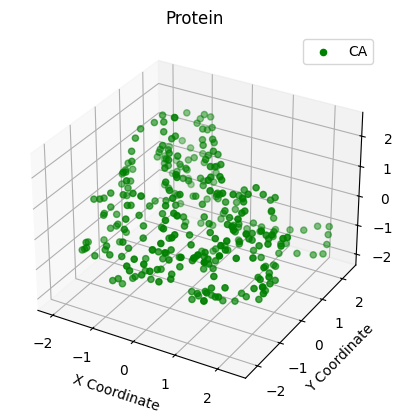

In [155]:
plot_protein(frames)

(array([  0.,   0.,   0.,   0.,   9.,  17.,  35.,  46.,  81., 109.,  65.,
         83.,  70.,  70.,  80.,  72.,  95., 101.,  84.,  47.,  31.,  43.,
         55.,  52.,  32.,  15.,  10.,   5.,   1.,   0.]),
 array([-3. , -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6, -1.4, -1.2, -1. ,
        -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,
         1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ]),
 <BarContainer object of 30 artists>)

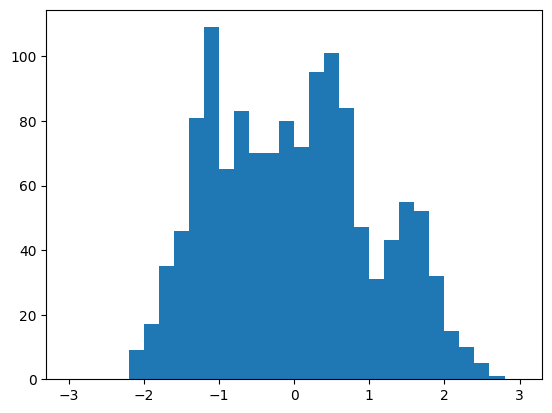

In [156]:
plt.hist(frames.flatten(end_dim=-2)[:,2],bins=30,range=(-3,3))

In [163]:
t2 = torch.tensor([10000])
x_pert,x_eps,h_pert,h_eps = test_diffusion(frames,torch.rand(frames.shape[0],3),t2)

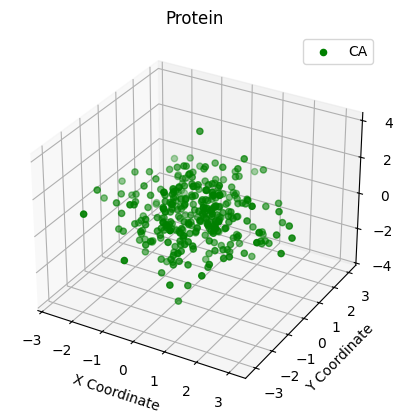

In [164]:
plot_protein(x_pert)

(array([ 1.,  2.,  1.,  1., 14., 13., 47., 62., 73., 67., 84., 92., 78.,
        74., 81., 67., 72., 61., 74., 56., 63., 50., 40., 34., 34., 29.,
        21., 11.,  6.,  0.]),
 array([-3. , -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6, -1.4, -1.2, -1. ,
        -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,
         1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ]),
 <BarContainer object of 30 artists>)

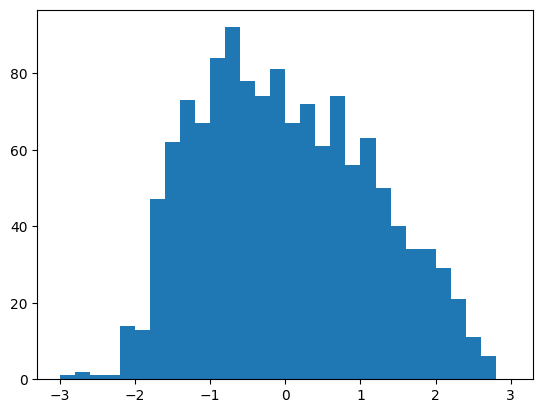

In [103]:
plt.hist(x_pert.flatten(end_dim=-2)[:,1],bins=30,range=(-3,3))